# System-Level Simulations

This notebook demonstrates how to perform system-level simulations with Sionna 
by integrating key functionalities from the SYS and PHY modules, including: 
- Base station placement on a a hexagonal spiral grid
- User drop within each sector
- 3GPP-compliant channel generation
- Proportional fair scheduler
- Power control
- Link adaptation for adaptive modulation and coding scheme (MCS) selection
- Post-equalization signal-to-interference-plus-noise (SINR) computation
- Physical layer abstraction

Below is the diagram flow underlying the system-level simulator we will
build in this notebook.

This is an advanced notebook. We recommend first exploring the tutorials on 
[physical layer abstraction](https://nvlabs.github.io/sionna/sys/tutorials/PHY_Abstraction.html), [link
adaptation](https://nvlabs.github.io/sionna/sys/tutorials/LinkAdaptation.html), and [scheduling](https://nvlabs.github.io/sionna/sys/tutorials/Scheduling.html).

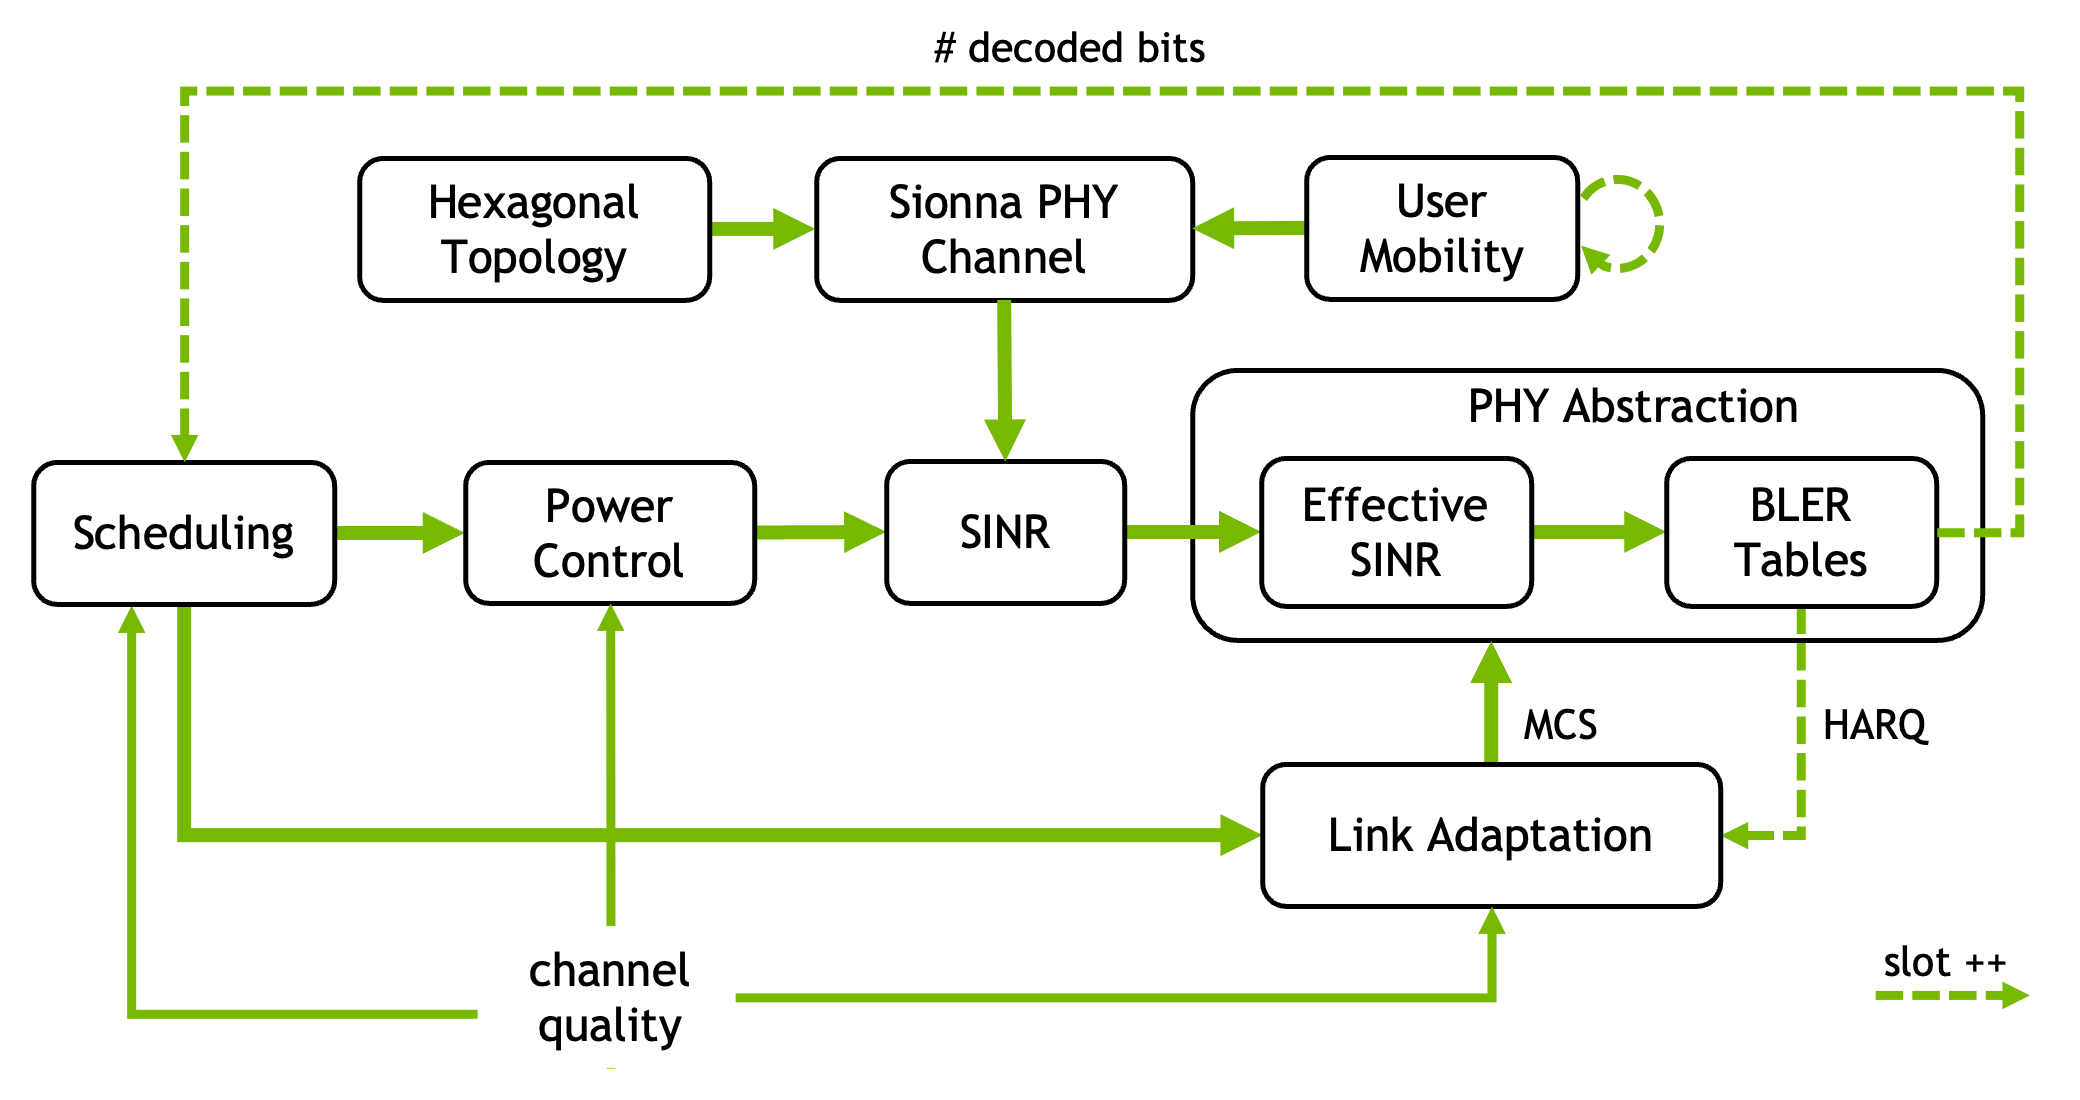

## Imports

We start by importing Sionna and the relevant external libraries:

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [ ]:
# Additional external libraries
import matplotlib.pyplot as plt
import numpy as np

# Sionna components
from sionna.sys.utils import spread_across_subcarriers
from sionna.sys import PHYAbstraction, \
    OuterLoopLinkAdaptation, gen_hexgrid_topology, \
    get_pathloss, open_loop_uplink_power_control, downlink_fair_power_control, \
    get_num_hex_in_grid, PFSchedulerSUMIMO
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.utils import db_to_lin, dbm_to_watt, log2, insert_dims
from sionna.phy import config, dtypes, Block
from sionna.phy.channel.tr38901 import UMi, UMa, RMa, PanelArray
from sionna.phy.channel import GenerateOFDMChannel
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, EyePrecodedChannel, \
    LMMSEPostEqualizationSINR

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

## Utils

We will now define several auxiliary functions that are used in this notebook, including:
- Channel matrix evolution;
- User stream management;
- Signal-to-interference-plus-noise-ratio (SINR) computation;
- Achievable rate estimation.

### Channel matrix generation

We assume that channel matrix coefficients are regenerated from a specified 3GPP
model every `coherence_time` slots, following a typical block fading model.
For simplicity, we emulate the impact of fast fading by multiplying the channel
matrix by a factor that follows an autoregressive process evolving at each slot.

More realistic simulations would include channel evolution based on user
mobility in a ray-traced enviroment, as for example shown in
the notebook [Sionna SYS meets Sionna RT](https://nvlabs.github.com/sionna/sys/tutorials/SYS_Meets_RT.html).

In [25]:
class ChannelMatrix(Block):
    def __init__(self,
                 resource_grid,
                 batch_size,
                 num_rx,
                 num_tx,
                 coherence_time,
                 precision=None):
        super().__init__(precision=precision)
        self.resource_grid = resource_grid
        self.coherence_time = coherence_time
        self.batch_size = batch_size
        # Fading autoregressive coefficient initialization
        self.rho_fading = config.tf_rng.uniform([batch_size, num_rx, num_tx],
                                                minval=.95,
                                                maxval=.99,
                                                dtype=self.rdtype)
        # Fading initialization
        self.fading = tf.ones([batch_size, num_rx, num_tx],
                              dtype=self.rdtype)

    def call(self, channel_model):
        """ Generate OFDM channel matrix"""

        # Instantiate the OFDM channel generator
        ofdm_channel = GenerateOFDMChannel(channel_model,
                                           self.resource_grid)

        # [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
        h_freq = ofdm_channel(self.batch_size)
        return h_freq

    def update(self,
               channel_model,
               h_freq,
               slot):
        """ Update channel matrix every coherence_time slots """
        # Generate new channel realization
        h_freq_new = self.call(channel_model)

        # Change to new channel every coherence_time slots
        change = tf.cast(tf.math.mod(
            slot, self.coherence_time) == 0, self.cdtype)
        h_freq = change * h_freq_new + \
            (tf.cast(1, self.cdtype) - change) * h_freq
        return h_freq

    def apply_fading(self,
                     h_freq):
        """ Apply fading, modeled as an autoregressive process, to channel matrix """
        # Multiplicative fading factor evolving via an AR process
        # [batch_size, num_rx, num_tx]
        self.fading = tf.cast(1, self.rdtype) - self.rho_fading + self.rho_fading * self.fading + \
            config.tf_rng.uniform(
                self.fading.shape, minval=-.1, maxval=.1, dtype=self.rdtype)
        self.fading = tf.maximum(self.fading, tf.cast(0, self.rdtype))
        # [batch_size, num_rx, 1, num_tx, 1, 1, 1]
        fading_expand = insert_dims(self.fading, 1, axis=2)
        fading_expand = insert_dims(fading_expand, 3, axis=4)

        # Channel matrix in the current slot
        h_freq_fading = tf.cast(tf.math.sqrt(
            fading_expand), self.cdtype) * h_freq
        return h_freq_fading

### User stream management

The
[StreamManagement](https://nvlabs.github.io/sionna/phy/api/mimo.html#stream-management)
class configures which base station serves which user.  
We assume here for
simplicity that each receiver is associated with the nearest base station.

In [26]:
def get_stream_management(direction,
                          num_rx,
                          num_tx,
                          num_streams_per_ut,
                          num_ut_per_sector):
    """
    Instantiate a StreamManagement object.
    It determines which data streams are intended for each receiver
    """
    if direction == 'downlink':
        num_streams_per_tx = num_streams_per_ut * num_ut_per_sector
        # RX-TX association matrix
        rx_tx_association = np.zeros([num_rx, num_tx])
        idx = np.array([[i1, i2] for i2 in range(num_tx) for i1 in
                        np.arange(i2*num_ut_per_sector,
                                  (i2+1)*num_ut_per_sector)])
        rx_tx_association[idx[:, 0], idx[:, 1]] = 1

    else:
        num_streams_per_tx = num_streams_per_ut
        # RX-TX association matrix
        rx_tx_association = np.zeros([num_rx, num_tx])
        idx = np.array([[i1, i2] for i1 in range(num_rx) for i2 in
                        np.arange(i1*num_ut_per_sector,
                                  (i1+1)*num_ut_per_sector)])
        rx_tx_association[idx[:, 0], idx[:, 1]] = 1

    stream_management = StreamManagement(
        rx_tx_association, num_streams_per_tx)
    return stream_management

### SINR computation

Computing the signal-to-noise-plus-interference-ratio (SINR) is
the first step to determine the block error rate (BLER) and, eventually, the user
throughput, via the physical layer abstraction.

In [27]:
def get_sinr(tx_power,
             stream_management,
             no,
             direction,
             h_freq_fading,
             num_bs,
             num_ut_per_sector,
             num_streams_per_ut,
             resource_grid):
    """ Compute post-equalization SINR. It is assumed:
     - DL: Regularized zero-forcing precoding
     - UL: No precoding, only power allocation
    LMMSE equalizer is used in both DL and UL.
    """
    # tx_power: [batch_size, num_bs, num_tx_per_sector,
    #            num_streams_per_tx, num_ofdm_sym, num_subcarriers]
    # Flatten across sectors
    # [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, num_subcarriers]
    s = tx_power.shape
    tx_power = tf.reshape(tx_power, [s[0], s[1]*s[2]] + s[3:])

    # Compute SINR
    # [batch_size, num_ofdm_sym, num_subcarriers, num_ut,
    #  num_streams_per_ut]
    if direction == 'downlink':
        # Regularized zero-forcing precoding in the DL
        precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                              stream_management=stream_management)
        h_eff = precoded_channel(h_freq_fading,
                                 tx_power=tx_power,
                                 alpha=no)  # Regularizer
    else:
        # No precoding in the UL: just power allocation
        precoded_channel = EyePrecodedChannel(resource_grid=resource_grid,
                                              stream_management=stream_management)
        h_eff = precoded_channel(h_freq_fading,
                                 tx_power=tx_power)

    # LMMSE equalizer
    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management)
    # Post-equalization SINR
    # [batch_size, num_ofdm_symbols, num_subcarriers, num_rx, num_streams_per_rx]
    sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)

    # [batch_size, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
    sinr = tf.reshape(
        sinr, sinr.shape[:-2] + [num_bs*num_ut_per_sector, num_streams_per_ut])

    # Regroup by sector
    # [batch_size, num_ofdm_symbols, num_subcarriers, num_bs, num_ut_per_sector, num_streams_per_ut]
    sinr = tf.reshape(
        sinr, sinr.shape[:-2] + [num_bs, num_ut_per_sector, num_streams_per_ut])

    # [batch_size, num_bs, num_ofdm_sym, num_subcarriers, num_ut_per_sector, num_streams_per_ut]
    sinr = tf.transpose(sinr, [0, 3, 1, 2, 4, 5])
    return sinr

### Estimation of Achievable Rate

To fairly allocate users to the appropriate time and frequency resources, the
proportional fairness (PF) scheduler must first estimate the *achievable* rate for
each user.

Users are then ranked based on the ratio of their achievable rate to
their *achieved* rate, called PF metric.  

Here, we assume that the achievable rate is estimated using the Shannon capacity
based on the effective SINR.  
The rate estimation is thus uniform across subcarriers, resulting in only one
user being scheduled per slot.

In [28]:
def estimate_achievable_rate(sinr_eff_db_last,
                             num_ofdm_sym,
                             num_subcarriers):
    """ Estimate achievable rate """
    # [batch_size, num_bs, num_ut_per_sector]
    rate_achievable_est = log2(tf.cast(1, sinr_eff_db_last.dtype) +
                               db_to_lin(sinr_eff_db_last))

    # Broadcast to time/frequency grid
    # [batch_size, num_bs, num_ofdm_sym, num_subcarriers, num_ut_per_sector]
    rate_achievable_est = insert_dims(
        rate_achievable_est, 2, axis=-2)
    rate_achievable_est = tf.tile(rate_achievable_est,
                                  [1, 1, num_ofdm_sym, num_subcarriers, 1])
    return rate_achievable_est

### Result recording

We record the relevant metrics in a dictionary for further analysis, including:
- Number of decoded bits;
- HARQ feedback;
- MCS index;
- Effective SINR;
- Pathloss of serving cell;
- Number of allocated REs;
- Proportional fairness (PF) metric;
- Transmit power;
- Outer-loop link adaptation (OLLA) offset.


In [29]:
def init_result_history(batch_size,
                        num_slots,
                        num_bs,
                        num_ut_per_sector):
    """ Initialize dictionary containing history of results """
    hist = {}
    for key in ['pathloss_serving_cell',
                'tx_power', 'olla_offset',
                'sinr_eff', 'pf_metric',
                'num_decoded_bits', 'mcs_index',
                'harq', 'num_allocated_re']:
        hist[key] = tf.TensorArray(
            size=num_slots,
            element_shape=[batch_size,
                           num_bs,
                           num_ut_per_sector],
            dtype=tf.float32)
    return hist


def record_results(hist,
                   slot,
                   sim_failed=False,
                   pathloss_serving_cell=None,
                   num_allocated_re=None,
                   tx_power_per_ut=None,
                   num_decoded_bits=None,
                   mcs_index=None,
                   harq_feedback=None,
                   olla_offset=None,
                   sinr_eff=None,
                   pf_metric=None,
                   shape=None):
    """ Record results of last slot """
    if not sim_failed:
        for key, value in zip(['pathloss_serving_cell', 'olla_offset', 'sinr_eff',
                               'num_allocated_re', 'tx_power', 'num_decoded_bits',
                               'mcs_index', 'harq'],
                              [pathloss_serving_cell, olla_offset, sinr_eff,
                               num_allocated_re, tx_power_per_ut, num_decoded_bits,
                               mcs_index, harq_feedback]):
            hist[key] = hist[key].write(slot, tf.cast(value, tf.float32))
        # Average PF metric across resources
        hist['pf_metric'] = hist['pf_metric'].write(
            slot, tf.reduce_mean(pf_metric, axis=[-2, -3]))
    else:
        nan_tensor = tf.cast(tf.fill(shape,
                                     float('nan')), dtype=tf.float32)
        for key in hist:
            hist[key] = hist[key].write(slot, nan_tensor)
    return hist


def clean_hist(hist, batch=0):
    """ Extract batch, convert to Numpy, and mask metrics when user is not
    scheduled """
    # Extract batch and convert to Numpy
    for key in hist:
        try:
            # [num_slots, num_bs, num_ut_per_sector]
            hist[key] = hist[key].numpy()[:, batch, :, :]
        except:
            pass

    # Mask metrics when user is not scheduled
    hist['mcs_index'] = np.where(
        hist['harq'] == -1, np.nan, hist['mcs_index'])
    hist['sinr_eff'] = np.where(
        hist['harq'] == -1, np.nan, hist['sinr_eff'])
    hist['tx_power'] = np.where(
        hist['harq'] == -1, np.nan, hist['tx_power'])
    hist['num_allocated_re'] = np.where(
        hist['harq'] == -1, 0, hist['num_allocated_re'])
    hist['harq'] = np.where(
        hist['harq'] == -1, np.nan, hist['harq'])
    return hist

## Simulation

We now put everything together and create a system-level simulator Sionna block.
We will then demonstrate how to instantiate it and run simulations. 

### Sionna block

We next define a compound Sionna block called `SystemLevelSimulator` composed of multiple submodules.  
It is structured as follows:
- `__init__` method, which initializes the main modules, including:
    - 3GPP channel model;
    - Multicell topology and user drop
    - Stream management;
    - Physical layer abstraction;
    - Scheduler;
    - Link adaptation;
- `call` method, which loops over slots and performs:
    - Channel generation;
    - Channel estimation, assumed ideal;
    - User scheduling;
    - Power control;
    - Per-stream SINR computation;
    - Physical layer abstraction;
    - User mobility.

To enable scaling up to tens of sectors and hundreds of users, we shall use
XLA compilation by decorating the `call` method by `@tf.function(jit_compile=True)`.

In [30]:
class SystemLevelSimulator(Block):
    def __init__(self,
                 batch_size,
                 num_rings,
                 num_ut_per_sector,
                 carrier_frequency,
                 resource_grid,
                 scenario,
                 direction,
                 ut_array,
                 bs_array,
                 bs_max_power_dbm,
                 ut_max_power_dbm,
                 coherence_time,
                 pf_beta=0.98,
                 max_bs_ut_dist=None,
                 min_bs_ut_dist=None,
                 temperature=294,
                 o2i_model='low',
                 average_street_width=20.0,
                 average_building_height=5.0,
                 precision=None):
        super().__init__(precision=precision)

        assert scenario in ['umi', 'uma', 'rma']
        assert direction in ['uplink', 'downlink']
        self.scenario = scenario
        self.batch_size = int(batch_size)
        self.resource_grid = resource_grid
        self.num_ut_per_sector = int(num_ut_per_sector)
        self.direction = direction
        self.bs_max_power_dbm = bs_max_power_dbm  # [dBm]
        self.ut_max_power_dbm = ut_max_power_dbm  # [dBm]
        self.coherence_time = tf.cast(coherence_time, tf.int32)  # [slots]
        num_cells = get_num_hex_in_grid(num_rings)
        self.num_bs = num_cells * 3
        self.num_ut = self.num_bs * self.num_ut_per_sector
        self.num_ut_ant = ut_array.num_ant
        self.num_bs_ant = bs_array.num_ant
        if bs_array.polarization == 'dual':
            self.num_bs_ant *= 2
        if self.direction == 'uplink':
            self.num_tx, self.num_rx = self.num_ut, self.num_bs
            self.num_tx_ant, self.num_rx_ant = self.num_ut_ant, self.num_bs_ant
            self.num_tx_per_sector = self.num_ut_per_sector
        else:
            self.num_tx, self.num_rx = self.num_bs, self.num_ut
            self.num_tx_ant, self.num_rx_ant = self.num_bs_ant, self.num_ut_ant
            self.num_tx_per_sector = 1

        # Assume 1 stream for UT antenna
        self.num_streams_per_ut = resource_grid.num_streams_per_tx

        # Set TX-RX pairs via StreamManagement
        self.stream_management = get_stream_management(direction,
                                                       self.num_rx,
                                                       self.num_tx,
                                                       self.num_streams_per_ut,
                                                       num_ut_per_sector)
        # Noise power per subcarrier
        self.no = tf.cast(BOLTZMANN_CONSTANT * temperature *
                          resource_grid.subcarrier_spacing, self.rdtype)

        # Slot duration [sec]
        self.slot_duration = resource_grid.ofdm_symbol_duration * \
            resource_grid.num_ofdm_symbols

        # Initialize channel model based on scenario
        self._setup_channel_model(
            scenario, carrier_frequency, o2i_model, ut_array, bs_array,
            average_street_width, average_building_height)

        # Generate multicell topology
        self._setup_topology(num_rings, min_bs_ut_dist, max_bs_ut_dist)

        # Instantiate a PHY abstraction object
        self.phy_abs = PHYAbstraction(precision=self.precision)

        # Instantiate a link adaptation object
        self.olla = OuterLoopLinkAdaptation(
            self.phy_abs,
            self.num_ut_per_sector,
            batch_size=[self.batch_size, self.num_bs])

        # Instantiate a scheduler object
        self.scheduler = PFSchedulerSUMIMO(
            self.num_ut_per_sector,
            resource_grid.fft_size,
            resource_grid.num_ofdm_symbols,
            batch_size=[self.batch_size, self.num_bs],
            num_streams_per_ut=self.num_streams_per_ut,
            beta=pf_beta,
            precision=self.precision)

    def _setup_channel_model(self, scenario, carrier_frequency, o2i_model,
                             ut_array, bs_array, average_street_width,
                             average_building_height):
        """ Initialize appropriate channel model based on scenario """
        common_params = {
            'carrier_frequency': carrier_frequency,
            'ut_array': ut_array,
            'bs_array': bs_array,
            'direction': self.direction,
            'enable_pathloss': True,
            'enable_shadow_fading': True,
            'precision': self.precision
        }

        if scenario == 'umi':  # Urban micro-cell
            self.channel_model = UMi(o2i_model=o2i_model, **common_params)
        elif scenario == 'uma':  # Urban macro-cell
            self.channel_model = UMa(o2i_model=o2i_model, **common_params)
        elif scenario == 'rma':  # Rural macro-cell
            self.channel_model = RMa(
                average_street_width=average_street_width,
                average_building_height=average_building_height,
                **common_params)

    def _setup_topology(self, num_rings, min_bs_ut_dist, max_bs_ut_dist):
        """G enerate and set up network topology """
        self.ut_loc, self.bs_loc, self.ut_orientations, self.bs_orientations, \
            self.ut_velocities, self.in_state, self.los, self.bs_virtual_loc, self.grid = \
            gen_hexgrid_topology(
                batch_size=self.batch_size,
                num_rings=num_rings,
                num_ut_per_sector=self.num_ut_per_sector,
                min_bs_ut_dist=min_bs_ut_dist,
                max_bs_ut_dist=max_bs_ut_dist,
                scenario=self.scenario,
                los=True,
                return_grid=True,
                precision=self.precision)

        # Set topology in channel model
        self.channel_model.set_topology(
            self.ut_loc, self.bs_loc, self.ut_orientations,
            self.bs_orientations, self.ut_velocities,
            self.in_state, self.los, self.bs_virtual_loc)

    def _reset(self,
               bler_target,
               olla_delta_up):
        """  Reset OLLA and HARQ/SINR feedback """
        # Link Adaptation
        self.olla.reset()
        self.olla.bler_target = bler_target
        self.olla.olla_delta_up = olla_delta_up

        # HARQ feedback (no feedback, -1)
        last_harq_feedback = - tf.ones(
            [self.batch_size, self.num_bs, self.num_ut_per_sector],
            dtype=tf.int32)

        # SINR feedback
        sinr_eff_feedback = tf.ones(
            [self.batch_size, self.num_bs, self.num_ut_per_sector],
            dtype=self.rdtype)

        # N. decoded bits
        num_decoded_bits = tf.zeros(
            [self.batch_size, self.num_bs, self.num_ut_per_sector],
            tf.int32)
        return last_harq_feedback, sinr_eff_feedback, num_decoded_bits

    def _group_by_sector(self,
                         tensor):
        """ Group tensor by sector
        - Input: [batch_size, num_ut, num_ofdm_symbols]
        - Output: [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
        """
        tensor = tf.reshape(tensor, [self.batch_size,
                                     self.num_bs,
                                     self.num_ut_per_sector,
                                     self.resource_grid.num_ofdm_symbols])
        # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
        return tf.transpose(tensor, [0, 1, 3, 2])

    @tf.function(jit_compile=True)
    def call(self,
             num_slots,
             alpha_ul,
             p0_dbm_ul,
             bler_target,
             olla_delta_up,
             mcs_table_index=1,
             fairness_dl=0,
             guaranteed_power_ratio_dl=0.5):

        # -------------- #
        # Initialization #
        # -------------- #
        # Initialize result history
        hist = init_result_history(self.batch_size,
                                   num_slots,
                                   self.num_bs,
                                   self.num_ut_per_sector)

        # Reset OLLA and HARQ/SINR feedback
        last_harq_feedback, sinr_eff_feedback, num_decoded_bits = \
            self._reset(bler_target, olla_delta_up)

        # Initialize channel matrix
        self.channel_matrix = ChannelMatrix(self.resource_grid,
                                            self.batch_size,
                                            self.num_rx,
                                            self.num_tx,
                                            self.coherence_time,
                                            precision=self.precision)
        # [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_sym,
        #  num_subcarriers]
        h_freq = self.channel_matrix(self.channel_model)

        # --------------- #
        # Simulate a slot #
        # --------------- #
        def simulate_slot(slot,
                          hist,
                          harq_feedback,
                          sinr_eff_feedback,
                          num_decoded_bits,
                          h_freq):
            try:
                # ------- #
                # Channel #
                # ------- #
                # Update channel matrix
                h_freq = self.channel_matrix.update(self.channel_model,
                                                    h_freq,
                                                    slot)

                # Apply fading
                h_freq_fading = self.channel_matrix.apply_fading(h_freq)

                # --------- #
                # Scheduler #
                # --------- #
                # Estimate achievable rate
                # [batch_size, num_bs, num_ofdm_sym, num_subcarriers, num_ut_per_sector]
                rate_achievable_est = estimate_achievable_rate(
                    self.olla.sinr_eff_db_last,
                    self.resource_grid.num_ofdm_symbols,
                    self.resource_grid.fft_size)

                # SU-MIMO Proportional Fairness scheduler
                # [batch_size, num_bs, num_ofdm_sym, num_subcarriers,
                #  num_ut_per_sector, num_streams_per_ut]
                is_scheduled = self.scheduler(
                    num_decoded_bits,
                    rate_achievable_est)

                # N. allocated subcarriers
                num_allocated_sc = tf.minimum(tf.reduce_sum(
                    tf.cast(is_scheduled, tf.int32), axis=-1), 1)
                # [batch_size, num_bs, num_ofdm_sym, num_ut_per_sector]
                num_allocated_sc = tf.reduce_sum(
                    num_allocated_sc, axis=-2)

                # N. allocated resources per slot
                # [batch_size, num_bs, num_ut_per_sector]
                num_allocated_re = \
                    tf.reduce_sum(tf.cast(is_scheduled, tf.int32),
                                  axis=[-1, -3, -4])

                # ------------- #
                # Power control #
                # ------------- #
                # Compute pathloss
                # [batch_size, num_rx, num_tx, num_ofdm_symbols], [batch_size, num_ut, num_ofdm_symbols]
                pathloss_all_pairs, pathloss_serving_cell = get_pathloss(
                    h_freq_fading,
                    rx_tx_association=tf.convert_to_tensor(
                        self.stream_management.rx_tx_association))
                # Group by sector
                # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
                pathloss_serving_cell = self._group_by_sector(
                    pathloss_serving_cell)

                if self.direction == 'uplink':
                    # Open-loop uplink power control
                    # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
                    tx_power_per_ut = open_loop_uplink_power_control(
                        pathloss_serving_cell,
                        num_allocated_sc,
                        alpha=alpha_ul,
                        p0_dbm=p0_dbm_ul,
                        ut_max_power_dbm=self.ut_max_power_dbm)
                else:
                    # Channel quality estimation:
                    # Estimate interference from neighboring base stations
                    # [batch_size, num_ut, num_ofdm_symbols]

                    one = tf.cast(1, pathloss_serving_cell.dtype)

                    # Total received power
                    # [batch_size, num_ut, num_ofdm_symbols]
                    rx_power_tot = tf.reduce_sum(
                        one / pathloss_all_pairs, axis=-2)
                    # [batch_size, num_bs, num_ut_per_sector, num_ofdm_symbols]
                    rx_power_tot = self._group_by_sector(rx_power_tot)

                    # Interference from neighboring base stations
                    interference_dl = rx_power_tot - one / pathloss_serving_cell
                    interference_dl *= dbm_to_watt(self.bs_max_power_dbm)

                    # Fair downlink power allocation
                    # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
                    tx_power_per_ut, _ = downlink_fair_power_control(
                        pathloss_serving_cell,
                        interference_dl + self.no,
                        num_allocated_sc,
                        bs_max_power_dbm=self.bs_max_power_dbm,
                        guaranteed_power_ratio=guaranteed_power_ratio_dl,
                        fairness=fairness_dl,
                        precision=self.precision)

                # For each user, distribute the power uniformly across
                # subcarriers and streams
                # [batch_size, num_bs, num_tx_per_sector,
                #  num_streams_per_tx, num_ofdm_sym, num_subcarriers]
                tx_power = spread_across_subcarriers(
                    tx_power_per_ut,
                    is_scheduled,
                    num_tx=self.num_tx_per_sector,
                    precision=self.precision)

                # --------------- #
                # Per-stream SINR #
                # --------------- #
                # [batch_size, num_bs, num_ofdm_sym, num_subcarriers,
                #  num_ut_per_sector, num_streams_per_ut]
                sinr = get_sinr(tx_power,
                                self.stream_management,
                                self.no,
                                self.direction,
                                h_freq_fading,
                                self.num_bs,
                                self.num_ut_per_sector,
                                self.num_streams_per_ut,
                                self.resource_grid)

                # --------------- #
                # Link adaptation #
                # --------------- #
                # [batch_size, num_bs, num_ut_per_sector]
                mcs_index = self.olla(num_allocated_re,
                                      harq_feedback=harq_feedback,
                                      sinr_eff=sinr_eff_feedback)

                # --------------- #
                # PHY abstraction #
                # --------------- #
                # [batch_size, num_bs, num_ut_per_sector]
                num_decoded_bits, harq_feedback, sinr_eff, _, _ = self.phy_abs(
                    mcs_index,
                    sinr=sinr,
                    mcs_table_index=mcs_table_index,
                    mcs_category=int(self.direction == 'downlink'))

                # ------------- #
                # SINR feedback #
                # ------------- #
                # [batch_size, num_bs, num_ut_per_sector]
                sinr_eff_feedback = tf.where(num_allocated_re > 0,
                                             sinr_eff,
                                             tf.cast(0., self.rdtype))

                # Record results
                hist = record_results(hist,
                                      slot,
                                      sim_failed=False,
                                      pathloss_serving_cell=tf.reduce_sum(
                                          pathloss_serving_cell, axis=-2),
                                      num_allocated_re=num_allocated_re,
                                      tx_power_per_ut=tf.reduce_sum(
                                          tx_power_per_ut, axis=-2),
                                      num_decoded_bits=num_decoded_bits,
                                      mcs_index=mcs_index,
                                      harq_feedback=harq_feedback,
                                      olla_offset=self.olla.offset,
                                      sinr_eff=sinr_eff,
                                      pf_metric=self.scheduler.pf_metric)

            except tf.errors.InvalidArgumentError as e:
                print(f"SINR computation did not succeed at slot {slot}.\n"
                      f"Error message: {e}. Skipping slot...")
                hist = record_results(hist, slot,
                                      shape=[self.batch_size,
                                             self.num_bs,
                                             self.num_ut_per_sector], sim_failed=True)

            # ------------- #
            # User mobility #
            # ------------- #
            self.ut_loc = self.ut_loc + self.ut_velocities * self.slot_duration

            # Set topology in channel model
            self.channel_model.set_topology(
                self.ut_loc, self.bs_loc, self.ut_orientations,
                self.bs_orientations, self.ut_velocities,
                self.in_state, self.los, self.bs_virtual_loc)

            return [slot + 1, hist, harq_feedback, sinr_eff_feedback,
                    num_decoded_bits, h_freq]

        # --------------- #
        # Simulation loop #
        # --------------- #
        _, hist, *_ = tf.while_loop(
            lambda i, *_: i < num_slots,
            simulate_slot,
            [0, hist, last_harq_feedback, sinr_eff_feedback,
             num_decoded_bits, h_freq])

        for key in hist:
            hist[key] = hist[key].stack()
        return hist

### Scenario parameters

To initialize the system-level simulator, we must define the following parameters:
- 3GPP desidered scenario and the multicell grid;
- Communication direction (downlink or uplink);
- OFDM resource grid configuration;
- Modulation and coding scheme table;
- Transmit power for the base stations and user terminals;
- Antenna arrays at the base stations and user terminals.


In [31]:
# Communication direction
direction = 'downlink'  # 'uplink' or 'downlink'

# 3GPP scenario parameters
scenario = 'umi'  # 'umi', 'uma' or 'rma'

# Number of rings of the hexagonal grid
# With num_rings=1, 7*3=21 base stations are placed
num_rings = 1

# N. users per sector
num_ut_per_sector = 10

# Max/min distance between base station and served users
max_bs_ut_dist = 80  # [m]
min_bs_ut_dist = 0  # [m]

# Carrier frequency
carrier_frequency = 3.5e9  # [Hz]

# Transmit power for base station and user terminals
bs_max_power_dbm = 56  # [dBm]
ut_max_power_dbm = 26  # [dBm]

# Channel is regenerated every coherence_time slots
coherence_time = 100  # [slots]

# MCS table index
# Ranges within [1;4] for downlink and [1;2] for uplink, as in TS 38.214
mcs_table_index = 1

# Number of examples
batch_size = 1

In [32]:
# Create the antenna arrays at the base stations
bs_array = PanelArray(num_rows_per_panel=2,
                      num_cols_per_panel=3,
                      polarization='dual',
                      polarization_type='VH',
                      antenna_pattern='38.901',
                      carrier_frequency=carrier_frequency)

# Create the antenna array at the user terminals
ut_array = PanelArray(num_rows_per_panel=1,
                      num_cols_per_panel=1,
                      polarization='single',
                      polarization_type='V',
                      antenna_pattern='omni',
                      carrier_frequency=carrier_frequency)

In [33]:
# n. OFDM symbols, i.e., time samples, in a slot
num_ofdm_sym = 1
# N. available subcarriers
num_subcarriers = 128
# Subcarrier spacing, i.e., bandwitdh width of each subcarrier
subcarrier_spacing = 15e3  # [Hz]

# Create the OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_sym,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_ut_per_sector,
                             num_streams_per_tx=ut_array.num_ant)

### Simulator initialization

We can now initialize the `SystemLevelSimulator` block by providing the
scenario parameters as inputs.

In [34]:
# Initialize SYS object
sls = SystemLevelSimulator(
    batch_size,
    num_rings,
    num_ut_per_sector,
    carrier_frequency,
    resource_grid,
    scenario,
    direction,
    ut_array,
    bs_array,
    bs_max_power_dbm,
    ut_max_power_dbm,
    coherence_time,
    max_bs_ut_dist=max_bs_ut_dist,
    min_bs_ut_dist=min_bs_ut_dist,
    temperature=294,  # Environment temperature for noise power computation
    o2i_model='low',  # 'low' or 'high',
    average_street_width=20.,
    average_building_height=10.)

We visualize below the multicell topology we just created:

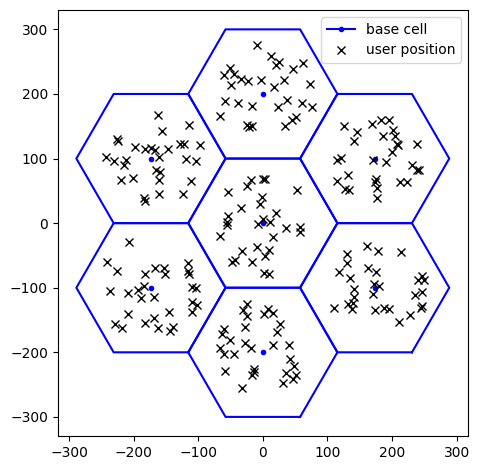

In [35]:
fig = sls.grid.show()
ax = fig.get_axes()
ax[0].plot(sls.ut_loc[0, :, 0], sls.ut_loc[0, :, 1],
           'xk', label='user position')
ax[0].legend()
plt.show()

We observe that:

- The base stations are placed on a hexagonal spiral grid with the defined
  number of rings;
- The inter-site distance depends on the chosen 3GPP scenario;
- Users are dropped uniformly at random within each sector, within the maximum
  distance from the respective base station. 

**Remark**: Hand-over procedures are **not**
implemented in this notebook; users simply attach to the nearest base station.  
As a result, user located near the cell edge may experience high interference.  
To mitigate this, the parameter `max_bs_ut_dist` can be adjusted to limit the
maximum distance between a user and its serving base station.

### Layer-2 parameters

Next, we define the parameters associated with the link
adaptation and power control modules, such as:
- BLER target, typically set to 10%;
- `olla_delta_up`, which determines how quickly outer-loop link
  adaptation (OLLA) adjusts the MCS index to the varying channel conditions;
- `(alpha_ul,p0_dbm_ul)`, defining the
  pathloss compensation factor and the target received power at the base
  station, respectively, in open-loop uplink power control;

as well as the number of slots to simulate.

In [36]:
# N. slots to simulate
num_slots = tf.constant(1000, tf.int32)

# Link Adaptation
bler_target = tf.constant(0.1, tf.float32)  # Must be in [0, 1]
olla_delta_up = tf.constant(0.2, tf.float32)

# Uplink power control parameters
# Pathloss compensation factor
alpha_ul = tf.constant(1., tf.float32)  # Must be in [0, 1]
# Target received power at the base station
p0_dbm_ul = tf.constant(-80., tf.float32)  # [dBm]

### Simulation

We are now finally ready to run system-level simulations on the defined 3GPP
multicell scenario!

In [37]:
# System-level simulations
hist = sls(num_slots,
           alpha_ul,
           p0_dbm_ul,
           bler_target,
           olla_delta_up)

2025-03-18 16:08:08.280558: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion_8', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_3', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_15', 8 bytes spill stores, 84 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion_25', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_15', 16 bytes spill stores, 16 bytes spill loads



## Performance metric analysis

In this last section, we extract insights from simulations by analyzing the output data
at the user granularity. 

First, we average the relevant metrics across slots:

In [38]:
hist = clean_hist(hist)

# Average across slots and store in dictionary
results_avg = {
    'TBLER': (1 - np.nanmean(hist['harq'], axis=0)).flatten(),
    'MCS': np.nanmean(hist['mcs_index'], axis=0).flatten(),
    '# decoded bits / slot': np.nanmean(hist['num_decoded_bits'], axis=0).flatten(),
    'Effective SINR [dB]': 10*np.log10(np.nanmean(hist['sinr_eff'], axis=0).flatten()),
    'OLLA offset': np.nanmean(hist['olla_offset'], axis=0).flatten(),
    'TX power [dBm]': 10*np.log10(np.nanmean(hist['tx_power'], axis=0).flatten()) + 30,
    'Pathloss [dB]': 10*np.log10(np.nanmean(hist['pathloss_serving_cell'], axis=0).flatten()),
    '# allocated REs / slot': np.nanmean(hist['num_allocated_re'], axis=0).flatten(),
    'PF metric': np.nanmean(hist['pf_metric'], axis=0).flatten()
}
metrics = list(results_avg.keys())

### A bird's eye view

We now visualize the cumulative density function (CDF) of the selected
metrics, averaged across slots and computed per user, including:
- Transport block error rate (TBLER): Indicates how well link adaptation maintained it near the target value.
- MCS index;
- Number of decoded bits per slot;
- Effective SINR: Measures the channel quality for each user;
- Outer-loop link adaptation (OLLA) offset: Reflects the extent to which OLLA corrected the SINR estimation;
- Transmit power;
- Pathloss from the serving cell;
- Number of allocated resource elements (RE);
- Proportional fairness (PF) metric: A lower value indicates a fairer resource allocation across users.


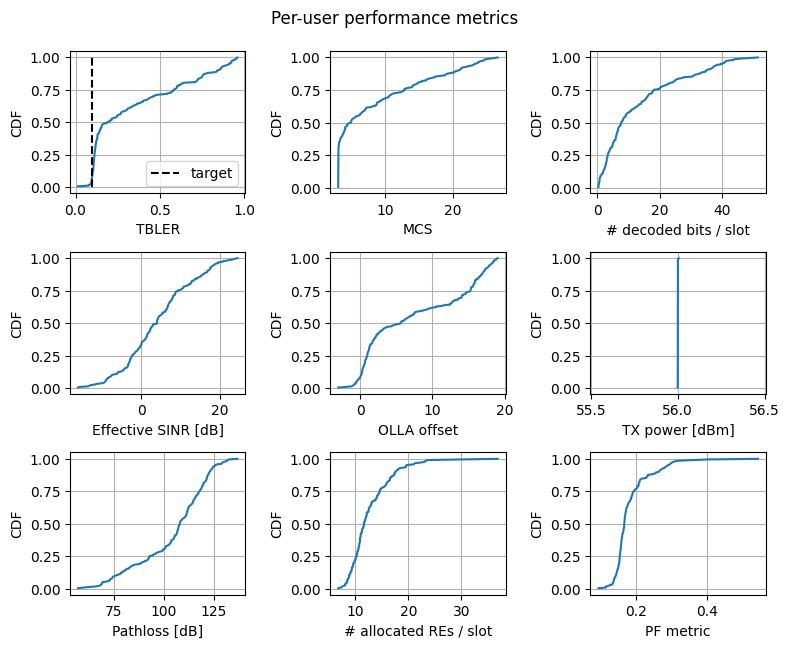

In [39]:
def get_cdf(values):
    """
    Computes the Cumulative Distribution Function (CDF) of the input
    """
    values = np.array(values).flatten()
    n = len(values)
    sorted_val = np.sort(values)
    cumulative_prob = np.arange(1, n+1) / n
    return sorted_val, cumulative_prob


fig, axs = plt.subplots(3, 3, figsize=(8, 6.5))
fig.suptitle('Per-user performance metrics', y=.99)

for ii in range(3):
    for jj in range(3):
        ax = axs[ii, jj]
        metric = metrics[3*ii+jj]
        ax.plot(*get_cdf(results_avg[metric]))
        if metric == 'TBLER':
            # Visualize BLER target
            ax.plot([bler_target]*2, [0, 1], '--k', label='target')
            ax.legend()
        if metric == 'TX power [dBm]':
            # Avoid plotting artifacts
            ax.set_xlim(ax.get_xlim()[0]-.5, ax.get_xlim()[1]+.5)
        ax.set_xlabel(metric)
        ax.grid()
        ax.set_ylabel('CDF')

fig.tight_layout()
plt.show()

We note that:

- For simulations in the downlink (`direction = downlink`), the transmit power per user remains constant and equals the
  base station's maximum transmit power.  
  This occurs because in the `SionnaSYS`
  block we chose, for simplicity, to feed the scheduler with a uniform
  achievable rate across subcarriers, resulting in only one user being scheduled
  per slot; 
- For uplink (`direction = uplink`), power varies significantly across users to compensate for the pathloss
  through the open-loop procedure. 

### MCS, SINR, and throughput

We next investigate the pairwise relationship among Modulation and Coding
Scheme (MCS), effective SINR, and throughput.

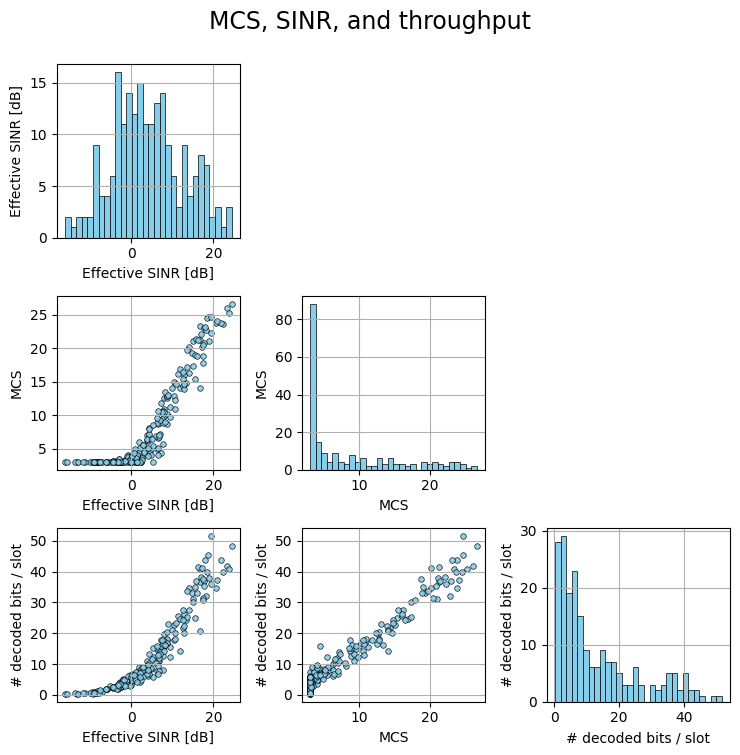

In [40]:
def pairplot(dict, keys, suptitle=None, figsize=2.5):
    fig, axs = plt.subplots(len(keys), len(keys),
                            figsize=[len(keys)*figsize]*2)
    for row, key_row in enumerate(keys):
        for col, key_col in enumerate(keys):
            ax = axs[row, col]
            ax.grid()
            if row == col:
                ax.hist(dict[key_row], bins=30,
                        color='skyblue', edgecolor='k',
                        linewidth=.5)
            elif col > row:
                fig.delaxes(ax)
            else:
                ax.scatter(dict[key_col], dict[key_row],
                           s=16, color='skyblue', alpha=0.9,
                           linewidths=.5, edgecolor='k')
            ax.set_ylabel(key_row)
            ax.set_xlabel(key_col)
    if suptitle is not None:
        fig.suptitle(suptitle, y=1, fontsize=17)
    fig.tight_layout()
    return fig, axs


fig, axs = pairplot(results_avg,
                    ['Effective SINR [dB]', 'MCS', '# decoded bits / slot'],
                    suptitle='MCS, SINR, and throughput')
plt.show()

As expected, as the SINR increases, higher MCS indices are used, resulting in higher throughput.

### Link adaptation

To main goal of link adaptation (LA) is to adapt the modulation and coding scheme
(MCS), thereby the transmission speed and reliability, to the evolving channel
conditions.

LA addresses this problem by maintaining the transport block error
rate (TBLER) around a pre-defined target, e.g., 10%, whenever possible.  

Since LA must deal with potentially outdated and noisy channel condition
feedback, it corrects the estimated SINR by applying an offset through a
feedback loop, known as outer-loop LA (OLLA).  
For more details on OLLA, please see [this notebook](https://nvlabs.github.io/sionna/sys/tutorials/LinkAdaptation.html).

Below we visualize the relationship among the TBLER, MCS index, and OLLA offset.

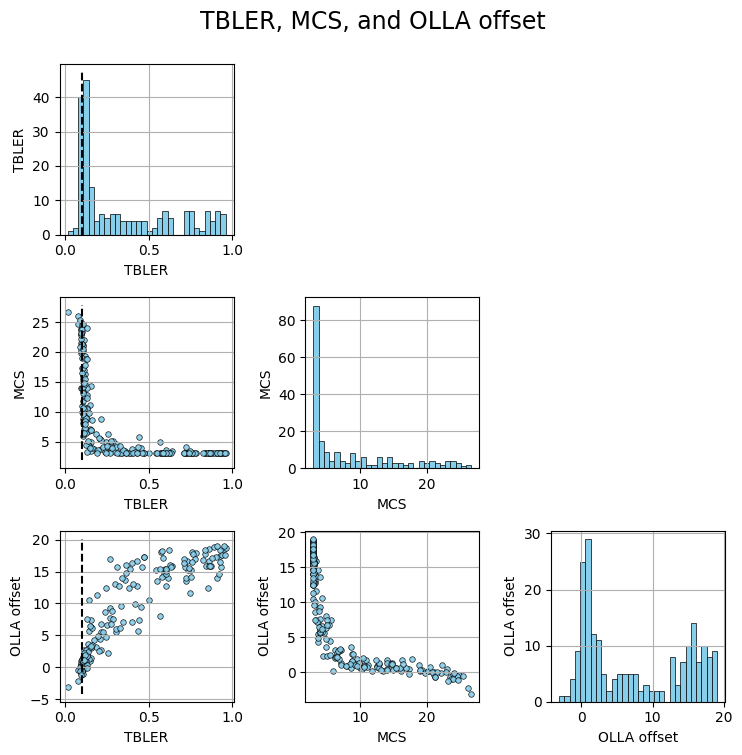

In [41]:
fig, axs = pairplot(results_avg,
                    ['TBLER', 'MCS', 'OLLA offset'],
                    suptitle='TBLER, MCS, and OLLA offset')
for ii in range(3):
    axs[ii, 0].plot([bler_target]*2, axs[ii, 0].get_ylim(), '--k')
plt.show()

From the MCS vs. TBLER figure we observe that the TBLER of users with low MCS
index, i.e., in bad channel conditions, is far from the target. This occurs
since at low MCS values, further spectral efficiency reduction is not feasible,
making it impossible to maintain the BLER at the target. For such users, the
OLLA offset tries to over-compensate, unsuccessfully, the estimated SINR (see offset vs. MCS figure).  

### Scheduler

The main principles of proportional fairness (PF) scheduling are to 
- Distribute the available time/frequency resources uniformly across users;
- Schedule users when their channel quality is high, relatively to their past average.

The scheduler assigns a resource to the user with the highest PF metric, which
is defined as the ratio between the achievable rate and the achieved throughput.  
An effective PF scheduler ensures that this metric remains low across all users.

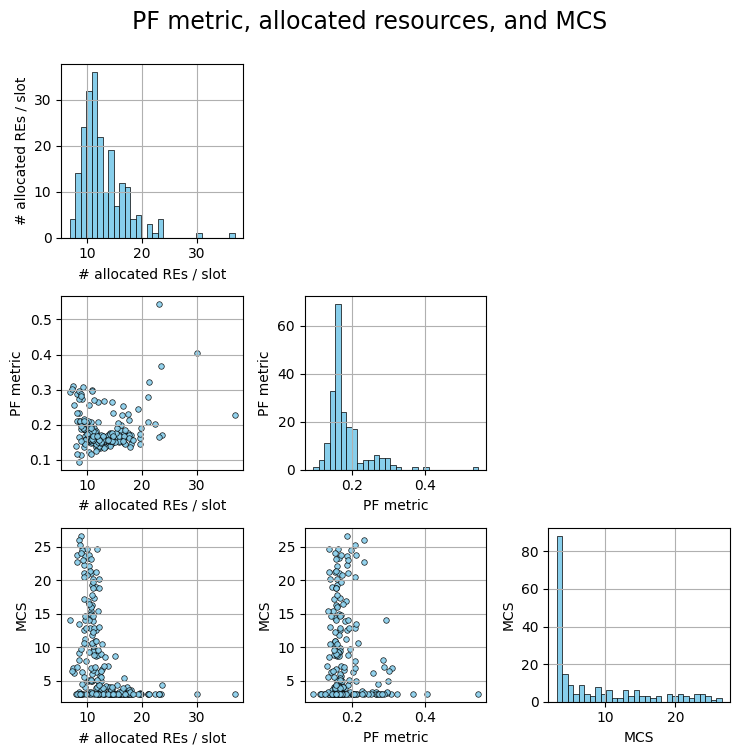

In [42]:
fig, axs = pairplot(results_avg,
                    ['# allocated REs / slot', 'PF metric', 'MCS'],
                    suptitle='PF metric, allocated resources, and MCS')
plt.show()

## Conclusions

Sionna SYS enables large-scale system-level simulations using
3GPP-compliant channel models generated via Sionna PHY.

We demonstrated how to integrate key SYS modules, including multicell
topology generation, phyisical layer abstraction, and layer-2 functionalities
such as link adaptation, scheduling, and power control.

To simplify the implementation, we assume *perfect* channel estimation and *exclude* handover management.

For a more straightforward example of assembling the SYS modules together with
ray-traced channels, we refer to the
[Sionna SYS meets RT notebook](https://nvlabs.github.io/sionna/sys/tutorials/SYS_Meets_RT.html).